In [ ]:
#Plotting libraries:
from __future__ import division, print_function
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch


import pandas as pd
import numpy as np

#sklearn library:
from datetime import datetime
import os, sys
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.python.client import device_lib


# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras


#gemerate array from csv:
from numpy import genfromtxt

#randomly select images from a direcetory:
import os, random

#Import tqdm for progress bar
from tqdm import tqdm

#for unormalising:
import math
from sklearn.preprocessing import MinMaxScaler


from scipy.interpolate import griddata
import time

## Import Data from Drive and Prepare Data:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd 'drive/My Drive/Internships/UKAEA Internship/data/block2_heat'

[Errno 2] No such file or directory: 'drive/My Drive/Internships/UKAEA Internship/data/block2_heat'
/content/drive/My Drive/Internships/UKAEA Internship/data/block2_heat


In [ ]:
import glob
data = glob.glob('/content/drive/My Drive/Internships/UKAEA Internship/data/block2_heat' + '/*.csv')

data.sort() #put in order

In [ ]:
tot_data = []


for i in data: #import csv for each timestep then append to above empty array
  single_time = pd.read_csv(i, delimiter = ',')

  single_time = np.array(single_time)


  tot_data.append(single_time)


t_d = np.stack(tot_data) #total data
print(np.shape(t_d))

(101, 3804, 6)


In [ ]:
#isolate time array:

ts_time = []

for i in range(0, np.shape(t_d)[0]  ): #loop for each timestep
  t = (t_d[i])[100][0] #pick some random row no. (picked 200 here) bc they are all the same


  ts_time.append(t)



print(ts_time)

[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 1000.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0, 410.0, 420.0, 430.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0, 500.0, 510.0, 520.0, 530.0, 540.0, 550.0, 560.0, 570.0, 580.0, 590.0, 600.0, 610.0, 620.0, 630.0, 640.0, 650.0, 660.0, 670.0, 680.0, 690.0, 700.0, 710.0, 720.0, 730.0, 740.0, 750.0, 760.0, 770.0, 780.0, 790.0, 800.0, 810.0, 820.0, 830.0, 840.0, 850.0, 860.0, 870.0, 880.0, 890.0, 900.0, 910.0, 920.0, 930.0, 940.0, 950.0, 960.0, 970.0, 980.0, 990.0]


In [ ]:
#obtain x, y and temp columns for each timestep:
# shape of below data = (timestep no., row no., column no.)

all_temp = t_d[0:, 0: , 5:6]

all_xcoord = t_d[0:, 0: , 1:2]
all_ycoord = t_d[0:, 0: , 2:3]

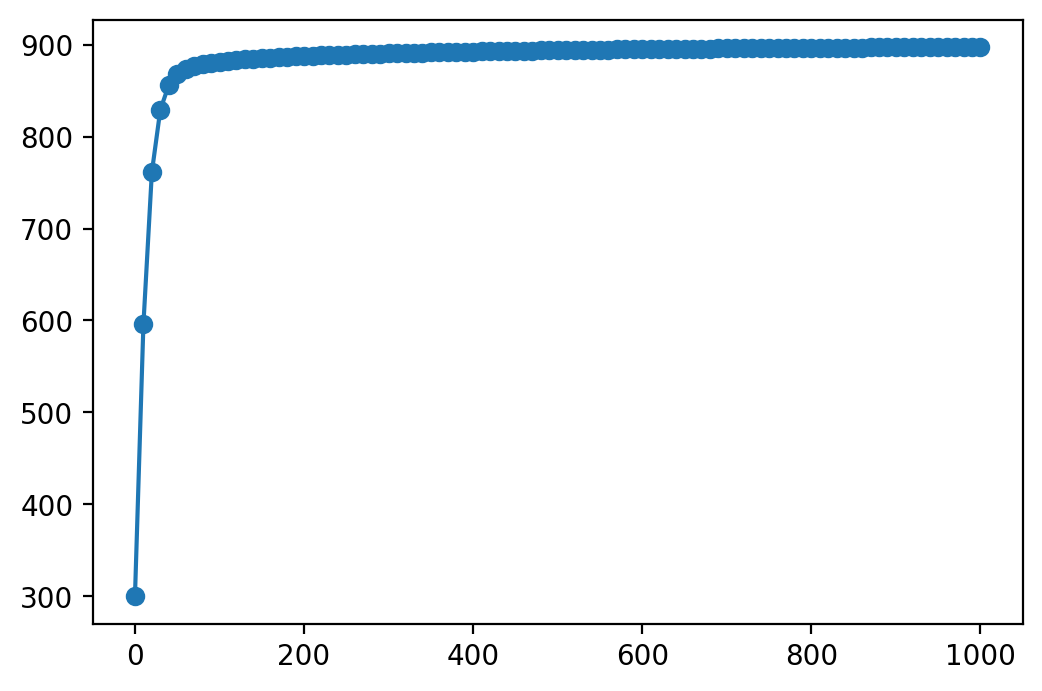

In [ ]:
#temperature for one coordinate across all timesteps:

plt.figure()
plt.plot(ts_time , np.reshape( all_temp[0:, 200:201], all_temp[0:, 300:301].size), '-o' )

## Classes to form, from raw temperature data ('C), temperature distribution plot and interpolated temperature distribution plot

In [ ]:
class distribution_img:
  '''plot the heat distribution using inputted temperature
  data points and their coordinates
  '''
  def __init__(self, all_ycoord, all_xcoord, all_temp   ):
    self.all_ycoord  = all_ycoord
    self.all_xcoord = all_xcoord
    self.all_temp = all_temp


  def all_xyt(self):
    '''x, y   &   x, y and t in adjacent columns for each timestep
    '''
    #this is for the `image()` func below



    all_xy = []
    all_xytemp = []

    for i in range(0, np.shape(self.all_xcoord)[0]  ): #loop for all timesteps
      xy = np.append( self.all_xcoord[i], self.all_ycoord[i], axis=1) #x and y
      xyt = np.append( xy, self.all_temp[i], axis=1) #x, y and temp

      all_xy.append(xy)
      all_xytemp.append(xyt)

    all_xytemp = np.stack(all_xytemp)

    return all_xy, all_xytemp







  def xy_size(self):
    '''number of data points along x axis and number of data points long y axis
    '''
    xy_ratio = int(    ( max(self.all_xcoord[0])  - min(self.all_xcoord[0]) )   /  ( max(self.all_ycoord[0])  - min(self.all_ycoord[0]) )     ) #x range / y range


    x_size = np.sqrt(   xy_ratio  *  self.all_xcoord.shape[1]   )
    y_size = x_size/xy_ratio


    #EXPLANATION OF ABOVE 2 LINES:
    # y size * x size = no. of rows (ie data)
    # therefore:   y size = x size / ratio
    # therefore:  (x size * x size) / ratio =  no. of rows
    # therefore:   x size = sqrt(    ratio * no. of rows    )


    return int(x_size), int(y_size)



#NB: for the function above:  I picked first timestep to obtain the min,max and ratio (ie xxx[0])
#this is assuming all time steps have the same x and y range....
#if not then you can loop over all time steps and store xsize and y size in a list which can be indexed in the functions below within their loops



  def images(self):
    '''heat map for each timestep
    '''
    xmax = max(self.all_xcoord[0])
    xmin = min(self.all_xcoord[0])
    ymax = max(self.all_ycoord[0])
    ymin = min(self.all_ycoord[0])


    x_size = self.xy_size()[0]  #no. of points along x axis
    y_size = self.xy_size()[1]  #no. of points along y axis


    xsize_inp = (x_size ) * 1j #has to be inputted with +1 and must be imaginary for np.mgrid
    ysize_inp = (y_size ) * 1j


    points = self.all_xyt()[0] #x and y


    grid_x, grid_y = np.mgrid[xmin:xmax:xsize_inp, ymin:ymax:ysize_inp] #from x and y meshgrid

    all_images = []

    for i in range( self.all_xcoord.shape[0]): #loop for all timesteps
      grid = griddata(points[i], self.all_temp[i], (grid_x, grid_y), method='nearest')
      grid = grid.reshape( grid.shape[0], grid.shape[1]) #reshape to get rid of extra dim in order to plot

      all_images.append(grid)



    return all_images






  def plot(self, index):
    '''plot a heatmap for a single timestep

    index: timestep index
    '''


    plt.figure()
    plt.imshow( self.images()[index].T, origin='lower', cmap='jet')  #transpose grid to make it x vs y, instead of y vs x
    plt.title('Temperature Distribution Across Domain at t={}s'.format(index))


    cb = plt.colorbar()
    cb.set_label("Temperature ('C)")
    plt.tight_layout()

    os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data/original_temp_images') #change directory to save in specific folder


    plt.savefig('Temperature_{}.png'.format(index))
    os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data/block2_heat') #change back directory







  def plot_train(self, index):
    '''plot a heatmap for a single timestep for training data
    (only difference =  storing images in diff directory + diff name)

    index: timestep index
    '''


    plt.figure()
    plt.imshow( self.images()[index].T, origin='lower', cmap='jet')  #transpose grid to make it x vs y, instead of y vs x
    plt.title('Temperature Distribution Across Domain at t={}s (Training_Data'.format(index))


    cb = plt.colorbar()
    cb.set_label("Temperature ('C)")
    plt.tight_layout()

    os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data/training_temp_images') #change directory to save in specific folder


    plt.savefig('Training_Temperature_{}.png'.format(index))
    os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data/block2_heat') #change back directory








  def plot_pred(self, index):
    '''plot a heatmap for a single timestep for predicted temp
      (only difference =  storing images in diff directory + diff name)

    index: timestep index
    '''


    plt.figure()
    plt.imshow( self.images()[index].T, origin='lower', cmap='jet')  #transpose grid to make it x vs y, instead of y vs x
    plt.title('Predicted Temperature Distribution Across Domain at t={}s'.format(index))


    cb = plt.colorbar()
    cb.set_label("Temperature ('C)")
    plt.tight_layout()

    os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data/prediction_images') #change directory to save in specific folder


    plt.savefig('Predict_Temperature_{}.png'.format(index))
    os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data/block2_heat') #change back directory





  def plot_interp(self, index):
    '''plot a heatmap for a single timestep for intperpolated temp
      (only difference =  storing images in diff directory + diff name)

    index: timestep index
    '''


    plt.figure()
    plt.imshow( self.images()[index].T, origin='lower', cmap='jet')  #transpose grid to make it x vs y, instead of y vs x
    plt.title('Interpolated Temperature Distribution Across Domain at t={}s'.format(index))


    cb = plt.colorbar()
    cb.set_label("Temperature ('C)")
    plt.tight_layout()

    os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data/interpolated_temp_images') #change directory to save in specific folder


    plt.savefig('Interpolated_Temperature_{}.png'.format(index))
    os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data/block2_heat') #change back directory





  def plot_res(self, index):
    '''plot a heatmap for a single timestep for residual data
      (only difference =  storing images in diff directory + diff name)

    index: timestep index
    '''


    plt.figure()
    plt.imshow( self.images()[index].T, origin='lower', cmap='jet')  #transpose grid to make it x vs y, instead of y vs x
    plt.title('Residual at t={}s'.format(index))


    cb = plt.colorbar()
    cb.set_label("Temperature ('C)")
    plt.tight_layout()

    os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data/residual_images') #change directory to save in specific folder


    plt.savefig('Residual_{}.png'.format(index))
    os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data/block2_heat') #change back directory

In [ ]:
class interpolate_distribution:
  def __init__(self, all_ycoord, all_xcoord, all_temp  ):
    self.all_ycoord  = all_ycoord
    self.all_xcoord = all_xcoord
    self.all_temp = all_temp


  def xy_joint(self):
    '''x and y in adjacent columns for each timestep
    '''

    all_xy = []

    for i in range( self.all_xcoord.shape[0] ): #loop for all timesteps
      points = np.append(self.all_xcoord[i], self.all_ycoord[i], axis=1)

      all_xy.append(points)

    return all_xy



  def xy_max_min(self):
    xmax = max(  self.all_xcoord[0])
    xmin = min(  self.all_xcoord[0])

    ymax = max(  self.all_ycoord[0])
    ymin = min(  self.all_ycoord[0])


    return (xmax, xmin, ymax, ymin)



  def xy_ratio(self):
    xy_ratio = int(    ( max(self.all_xcoord[0])  - min(self.all_xcoord[0])    ) /  ( max(self.all_ycoord[0])  - min(self.all_ycoord[0])    )    ) #x range / y range

    return xy_ratio # = 3 for this data

#NB: for the 2 functions above:  I picked first timestep to obtain the min,max and ratio (ie xxx[0])
#this is assuming all time steps have the same x and y range....
#if not then you can loop over all time steps and store min,max and ratios in a list which can be indexed in the functions below within their loops




  def interp_grid(self, density):
    '''Interpolate the grid of temperature distribution
    '''

    xmax = self.xy_max_min()[0]
    xmin = self.xy_max_min()[1]
    ymax = self.xy_max_min()[2]
    ymin = self.xy_max_min()[3]


    x_size = self.xy_ratio()*100 *density  #no. of points along x axis... ratio = 3 for this data
    y_size = 1*100 *density  #no. of points along y axis
    #NB: set default density:  size = 300 x 100 (30000 temp points)... therefore `density` variable = how many times more dense than default


    xsize_inp = (x_size + 1) * 1j #has to be inputted with +1 and must be imaginary for np.mgrid
    ysize_inp = (y_size + 1) * 1j


    points = self.xy_joint()

    all_xgrid = []
    all_ygrid = []

    all_images = []

    for i in range( self.all_xcoord.shape[0]): #loop for all timesteps
      grid_x, grid_y = np.mgrid[xmin:xmax:xsize_inp, ymin:ymax:ysize_inp] #from x and y meshgrid

      grid = griddata(points[i], self.all_temp[i], (grid_x, grid_y), method='linear')
      grid = grid.reshape( grid.shape[0], grid.shape[1]) #reshape to get rid of extra dim in order to plot

      all_images.append(grid)

      all_xgrid.append(grid_x)
      all_ygrid.append(grid_y)


    return all_images, all_xgrid, all_ygrid #return x & y grid for replotting after training


  def plot(self, index):
    '''plot interpolated heatmap for a single timestep

    index: timestep ind
    '''

    plt.figure()
    plt.imshow(  ( self.interp_grid().T[0] )[index],       extent=(0, self.xy_ratio()   ,   0, 1),  origin='lower', cmap='jet')  #transpose grid to make it x vs y, instead of y vs x
    plt.colorbar()
    plt.title('Linear Interpolation')



In [ ]:
def interpolated_temp(all_ycoord, all_xcoord, all_temp, density):
  '''flat interpolatd temp, x and y data
  '''

  interp = interpolate_distribution( all_ycoord, all_xcoord, all_temp)

  #interp.xy_joint()
  #interp.xy_max_min()
  #interp.xy_ratio()

  temp_grid = interp.interp_grid(density )[0] #interpolated temperature distrubution on a grid!
  xgrid = interp.interp_grid(density )[1]
  ygrid = interp.interp_grid(density )[2]



  #flatten grids and make into array:

  temp = [] #temp data
  for i in range(all_xcoord.shape[0]): #loop for all timesteps
    temp_flat = temp_grid[i].flatten()
    temp_flat = np.array([temp_flat])

    temp.append(temp_flat)

  x = [] #x data
  for i in range(all_xcoord.shape[0]): #loop for all timesteps
    x_flat = xgrid[i].flatten()
    x_flat = np.array([x_flat])

    x.append(x_flat)

  y = [] #y data
  for i in range(all_xcoord.shape[0]): #loop for all timesteps
    y_flat = ygrid[i].flatten()
    y_flat = np.array([y_flat])

    y.append(y_flat)


  return temp, x, y #interpolated flat temp, x and y data

## Class to Train and Predict using RNN:

In [ ]:
class every_func:
  def __init__(self, inp_ydata, windowsize, offset, steps, input_nuerons, output_nuerons, time_data, dens_scale_factor, train_size  ):
    self.inp_ydata  = inp_ydata
    self.windowsize = windowsize
    self.offset = offset
    self.steps = steps
    self.input_nuerons = input_nuerons
    self.output_nuerons = output_nuerons
    self.time_data = time_data
    self.dens_scale_factor = dens_scale_factor
    self.train_size = train_size


  def interpolate(self):
    '''Interpolate the Data
    Input: time_data and input data
    Output: A 2 coloumn array of the denser time data and y data
    '''
    new_time = np.linspace(min(ts_time), max(ts_time), int(self.dens_scale_factor*len(ts_time)) + 1)  #denser time/x data by scale factor dens_scale_factor
    yinterp = np.interp(new_time, self.time_data, self.inp_ydata)  #evaluate new y data at the denser time/x data points

    return ([new_time, yinterp])


  def normalise(self):
    '''Normalise Data
    '''
    scaler = MinMaxScaler(feature_range=(0, 1))
    norm_arr = scaler.fit_transform(         np.array( self.interpolate()[1] ).reshape( np.array( self.interpolate()[1]).shape[0] , 1 )        )

    return norm_arr





  def shapeArray(self, arr):
    '''Labels and Input Arrays
    '''
    Input= np.array([arr[i : i + self.windowsize] for i in range(len(arr)-(self.windowsize + self.offset)+1)])   #input arrays
    Label= np.array([arr[i + self.windowsize : i+ self.windowsize + self.offset] for i in range( len(arr) - (self.windowsize + self.offset)+1)])  #label arrays
    return (Input,Label)





  def network(self):
    '''Reccurent Neural Network
    '''

    rnn = keras.models.Sequential()
    rnn.add(keras.layers.LSTM(self.input_nuerons, input_shape=(None,1),return_sequences=True)) # LSTM layer with 20 neurons
    #rnn.add(keras.layers.Dense(50, activation="relu"))
    #rnn.add(keras.layers.Dense(50, activation="relu"))
    rnn.add(keras.layers.Dense(101, activation="relu"))
    #^^^hidden dense layer... made a big difference!... same number of neurons as timesteps... did this have something to do with

    rnn.add(keras.layers.Dense(self.output_nuerons, activation="linear"))
    rnn.compile(loss='mse',optimizer='adam')
    #rnn.summary()

    return rnn




  def train_pred(self):
    '''Train NN and Predict Time Series
    Input: time_data and normalised input data
    Output: A 2 coloumn array of the loss for training and the predicted time series
    '''
    costs=np.zeros(  self.steps  ) #array of costs (all 0 atm)
    rnn= self.network() #call network


    #TRAIN#
    for i in tqdm(range(     self.steps  )):
      yInput, yLabel = self.shapeArray(   self.normalise()[0: int(   self.train_size*len(  self.normalise()  ))  ]) #shape input arrays + pick certain training size for input (train_size)


      # Now we need to reshape the array into batchsize * window size * features (1)
      y_in=yInput.reshape(yInput.shape[0],yInput.shape[1],1)  # Reshape the input array to have the dimensions (batchsize,time samples, features)
      # We only want a single number for the target (since we set return_sequences=False above). We will take the last sample of the yLabel
      y_target = yLabel[:,-1].reshape(yLabel.shape[0], 1) # Reshape the output array to have the dimensions (batchsize, time samples)

      costs[i] = rnn.train_on_batch(y_in , y_target) #Train the network and substitute costs into cost array


    #PREDICT#
    yInput_test, yLabel_test = self.shapeArray(self.normalise())  #shape test arrays + test data size is full size of original data
    yTest_in = yInput_test.reshape(yInput_test.shape[0], yInput_test.shape[1], 1)

    y_Test = rnn.predict_on_batch(   yTest_in.reshape(yTest_in.shape[0], self.windowsize, 1)   ) #predict


    return ([costs, y_Test])




  def unormalise(self, arr):
    '''Unormalise Data
    '''

    min_og = min(self.inp_ydata) #minimum of original data
    max_og = max(self.inp_ydata) #maximum of original data
    arr = np.array(arr)


    scaler2 = MinMaxScaler(   feature_range=(min_og, max_og+0.0001)   ) #range = min_og to max_og
    unorm_array = scaler2.fit_transform(    arr.reshape(    arr.shape[0], arr.shape[1]    )        )

    return unorm_array






  def costplot(self, costs ):
    '''Costs vs Epochs/Steps Plot
    '''
    fig,ax=plt.subplots()
    ax.plot(  np.arange(self.steps),  costs,label=r"Costs")
    ax.set_xlabel("Steps")
    ax.set_ylabel("Cost")
    ax.set_title("Network Training Cost")
    ax.legend()




  def pred_plot(self, pred):

    fig,ax = plt.subplots()
    ax.plot(self.time_data,  self.inp_ydata,   label="Target") #full data

    #input training data plot (train_size)
    ax.plot( self.time_data[0: int(self.train_size*len(self.time_data))],  self.inp_ydata[0: int(self.train_size*len(self.inp_ydata))]    ,label="Training Data")

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Variable at a certain coordinate")
    ax.set_title("Network Prediction")


    #unormalised prediction plot (unormalised interpolated prediction vs interpolated time):
    ax.plot(          (    self.interpolate()[0]       )[   self.windowsize+self.offset-1:] , self.unormalise(pred)[:,-1] , label="Prediction")
    #^^^[:,-1] is to output only the last prediction from the nn^^^

    ax.legend()







In [ ]:
def prediction(data, time_data, windowsize, offset, steps, input_nuerons, output_neurons, dens_scale_factor, train_size):
  '''interpolation, normalisation, shaping input data arrays,  rnn, training rnn, predicting using rnn, unormalising and plotting
  '''


  all = every_func(data, windowsize, offset, steps, input_nuerons, output_neurons, time_data, dens_scale_factor, train_size)

  #all.interpolate()
  #all.shapeArray(ts_disx)

  #all.allwork(4, 1)
  #all.train(0.6)

  train_pred = all.train_pred()

  #all.costplot(   train_pred[0]   )

  #all.pred_plot( train_pred[1] )

  return train_pred[0], all.unormalise(train_pred[1]), all.interpolate()[0] #losses, unormalisedpredictions and interpolated time

## Obtain Interpolated Temperature and Prediction:


In [ ]:
interp_temp = interpolated_temp(all_ycoord, all_xcoord, all_temp, 0.5)[0]
interp_x = interpolated_temp(all_ycoord, all_xcoord, all_temp, 0.5)[1]
interp_y = interpolated_temp(all_ycoord, all_xcoord, all_temp, 0.5)[2]



interp_temp = np.array(interp_temp) #must be array for the loop below
interp_temp = interp_temp.reshape(interp_temp.shape[0], interp_temp.shape[2], 1) #change shape from (101, 1, 30401) to (101, 30401, 1)

interp_x = np.array(interp_x) #must be array for the loops below
interp_x = interp_x.reshape(interp_x.shape[0], interp_x.shape[2], 1) #change shape from (101, 1, 30401) to (101, 30401, 1)

interp_y = np.array(interp_y) #must be array for the loops below
interp_y = interp_y.reshape(interp_y.shape[0], interp_y.shape[2], 1) #change shape from (101, 1, 30401) to (101, 30401, 1)

In [ ]:
start_time = time.time()


training_size = 0.6
steps = 100

predic = []
losses = []
#interp_time = []

coordinate =0

for i in range(  0,   np.shape(interp_temp)[1]  ): #loop over all coordinates
  all_data = np.reshape(    interp_temp[0:, i:(i+1)],  np.size( interp_temp[0:, i:(i+1)] )   )   #single throughout the time series

  if (  np.sum(all_data)>0): #make sure that timeseries is not constantly 0
    pred = prediction(  all_data  , ts_time, 1, 1, steps, 4, 1, 1, training_size)  #1 input, 1 output... 1 for each timestep...
    predic.append(pred[1]) # predictions
    losses.append(pred[0]) # losses
    #interp_time.append(pred[2]) #interpolated time

    coordinate = coordinate + 1
    print('The coordinate number so far is: ', coordinate)





time_taken = time.time() - start_time

print(time_taken)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#save prediction and losses arrays:


pred = np.reshape(predic,    ( np.shape(predic)[0], np.shape(predic)[1] )  )


np.savetxt("prediction.csv", pred, delimiter=",") #save final losses as csv
np.savetxt("losses.csv", losses, delimiter=",") #save final losses as csv

In [ ]:
#import saved prediction:


os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data') #change directory to save in specific folder


file = open("prediction.csv")
predic = np.loadtxt( file, delimiter=',')


os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data/block2_heat') #change directory to save in specific folder

In [ ]:
#import saves losses:


os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data') #change directory to save in specific folder


file = open("losses.csv")
losses = np.loadtxt( file, delimiter=',')


os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data/block2_heat') #change directory to save in specific folder

In [ ]:
# RESHAPE:

#shape of `predic`  is (no of coords, no of timesteps). So we have to convert to (no of timesteps, no of coords)
#ie (30000, 101) to (101, 30000)

print(np.shape(predic))
pred = np.reshape(predic,    ( np.shape(predic)[1], np.shape(predic)[0], 1 )  )
print(np.shape(pred))



(7701, 101)
(101, 7701, 1)


In [ ]:
#TURN FROM (COORDINATE, TIMESTEP, 1) BACK TO (TIMESTEP, COORDINATE, 1)... np.reshape does not work!



prediction = []
#predic = np.array(predic)
for i in range( 0, np.shape(predic)[1]  ):
  pred = np.reshape(         predic[0:, i:(i+1)]   ,    ( np.size( predic[0:, i:(i+1)] ) , 1)  )
  #pred = np.asarray([  pred  ])


  prediction.append(pred)


print(np.shape(prediction))
#print(np.reshape(  (prediction[0])  ) )
print(prediction[100])

(101, 7701, 1)
[[900.00012207]
 [900.00012207]
 [900.00006104]
 ...
 [300.        ]
 [300.        ]
 [300.        ]]


## Make ALL Animations:

In [ ]:
original_img = distribution_img(all_ycoord, all_xcoord, all_temp)


#PLOTS FOR FULL DATA:

for i in range(all_xcoord.shape[0]): #loop for all timesteps
  original_img.plot(i) #plot and save plot to certain directory (shown in function)
  plt.close() #dont display plot



#PLOTS FOR TRAINING DATA:
for i in range(   int(all_xcoord.shape[0]*training_size)   ):
  original_img.plot_train(i) #plot and save plot to certain directory (shown in function)
  plt.close()

In [ ]:
#PLOTS FOR INTERPOLATED:


interp_img = distribution_img(interp_y, interp_x, interp_temp)


for i in range(  all_xcoord.shape[0]   ):
  interp_img.plot_interp(i) #plot and save plot to certain directory (shown in function)
  plt.close()



In [ ]:
#PLOTS FOR PREDICTED:


pred_img = distribution_img(interp_y, interp_x, prediction) #use same interolated coordinates but predicted temp


for i in range(  all_xcoord.shape[0]  ):
  pred_img.plot_pred(i) #plot and save plot to certain directory (shown in function)
  plt.close()


In [ ]:
!pip install imageio
import imageio


#below function from: https://www.youtube.com/watch?v=879VnIEQ4AY&list=LL&index=17&ab_channel=SpatialeLearning
def make_gif(input_folder, save_filepath):
  episode_frames = []
  time_per_step = 0.040

  for root, _, files in os.walk(input_folder):
    file_paths = [os.path.join(root, file) for file in files]
    file_paths = sorted(file_paths, key=lambda x: os.path.getmtime(x))

    episode_frames = [imageio.imread(file_paths) for file_paths in file_paths if file_paths.endswith('.png')]

    episode_frames = np.array(episode_frames)

    imageio.mimsave(save_filepath, episode_frames, duration=time_per_step)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
original_directory = '/content/drive/My Drive/Internships/UKAEA Internship/data/original_temp_images'
training_directory = '/content/drive/My Drive/Internships/UKAEA Internship/data/training_temp_images'
interpolated_directory = '/content/drive/My Drive/Internships/UKAEA Internship/data/interpolated_temp_images'
predicted_directory = '/content/drive/My Drive/Internships/UKAEA Internship/data/prediction_images'


#create animation files:
make_gif(  original_directory,   os.path.join(original_directory, "Animation_Original_Temperature.gif")   )
make_gif(  training_directory,   os.path.join(training_directory, "Animation_Training_Temperature.gif")   )
make_gif(  interpolated_directory,   os.path.join(interpolated_directory, "Animation_Interpolated_Temperature.gif")   )
make_gif(  predicted_directory,   os.path.join(predicted_directory, "Animation_Predicted_Temperature.gif")   )

## Performance Metrics:

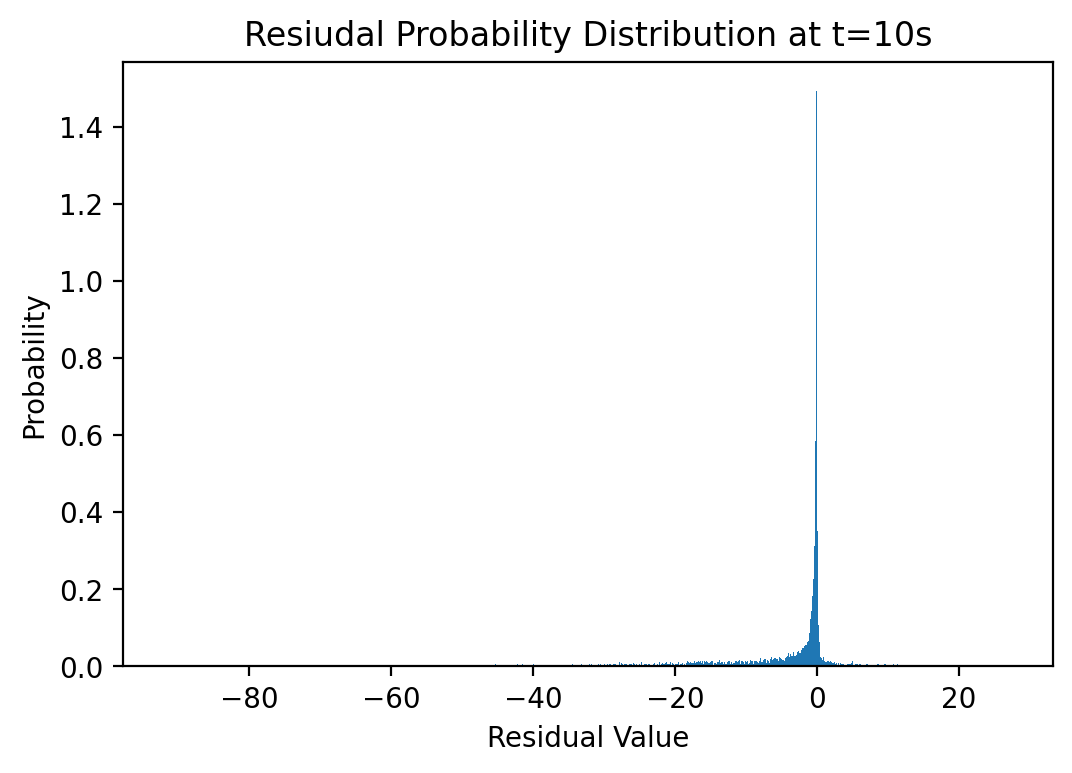

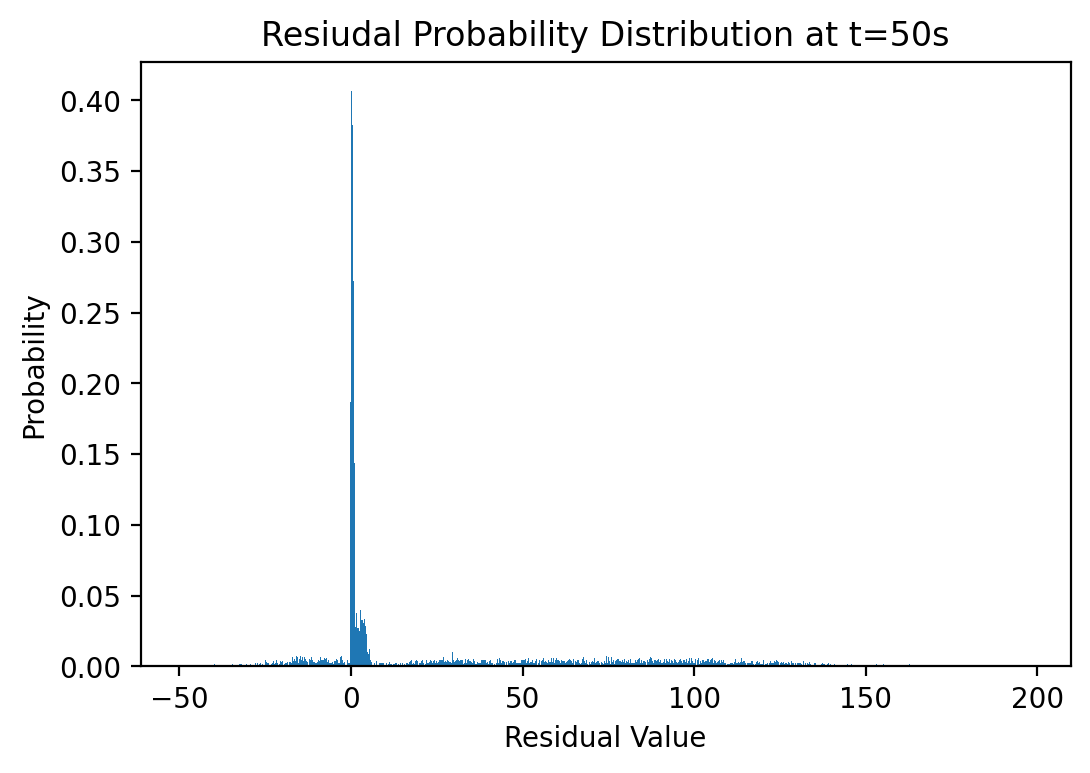

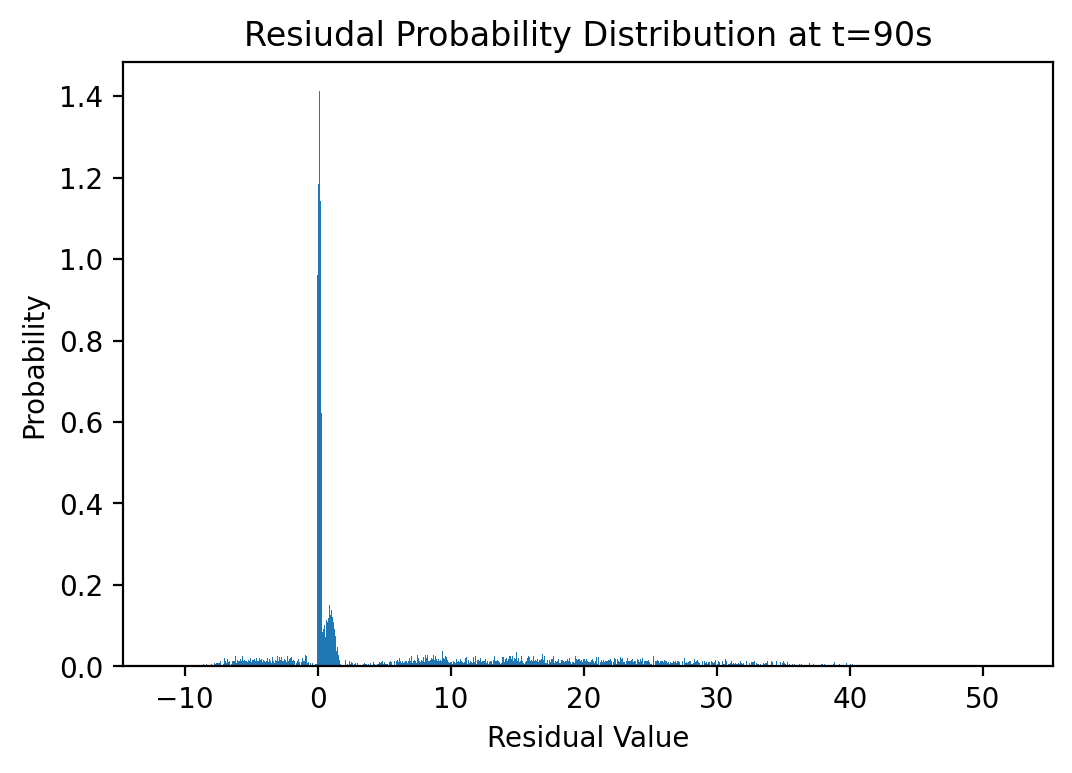

In [ ]:
#RESIDUAL + RESIDUAL ANIMATION:

#calculate differnec between predicted temp and inputted temp:

residual = []
for i in range(np.shape(prediction)[0]   ):
  res = interp_temp[i] - prediction[i] #residual

  residual.append(res)



res_img = distribution_img(interp_y, interp_x, residual) #use same interolated coordinates but predicted temp

for i in range(   interp_x.shape[0]    ):
  res_img.plot_res(i) #plot and save plot to certain directory (shown in function)
  plt.close()



residual_directory = '/content/drive/My Drive/Internships/UKAEA Internship/data/residual_images'
make_gif(  residual_directory,   os.path.join(residual_directory, "Animation_Residual_Temperature.gif")   )


# PLOT HISTOGRAM/PROBABILITY DISTRIBUTION:
os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data') #change directory to save in specific folder



plt.hist(residual[10], density=True, bins=1000)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Residual Value')
plt.title('Resiudal Probability Distribution at t=10s')
plt.savefig('Residual_Histogram_10s.png')
plt.show()

plt.hist(residual[50], density=True, bins=1000)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Residual Value')
plt.title('Resiudal Probability Distribution at t=50s')
plt.savefig('Residual_Histogram_50s.png')
plt.show()

plt.hist(residual[90], density=True, bins=1000)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Residual Value')
plt.title('Resiudal Probability Distribution at t=90s')
plt.savefig('Residual_Histogram_90s.png')
plt.show()



os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data/block2_heat') #change back directory

In [ ]:
steps = 100

The Mean of Final Losses for all Coordinates is:  0.006482818515765516
The Standard Deviation of Final Losses for all Coordinates is:  0.006190173662214106


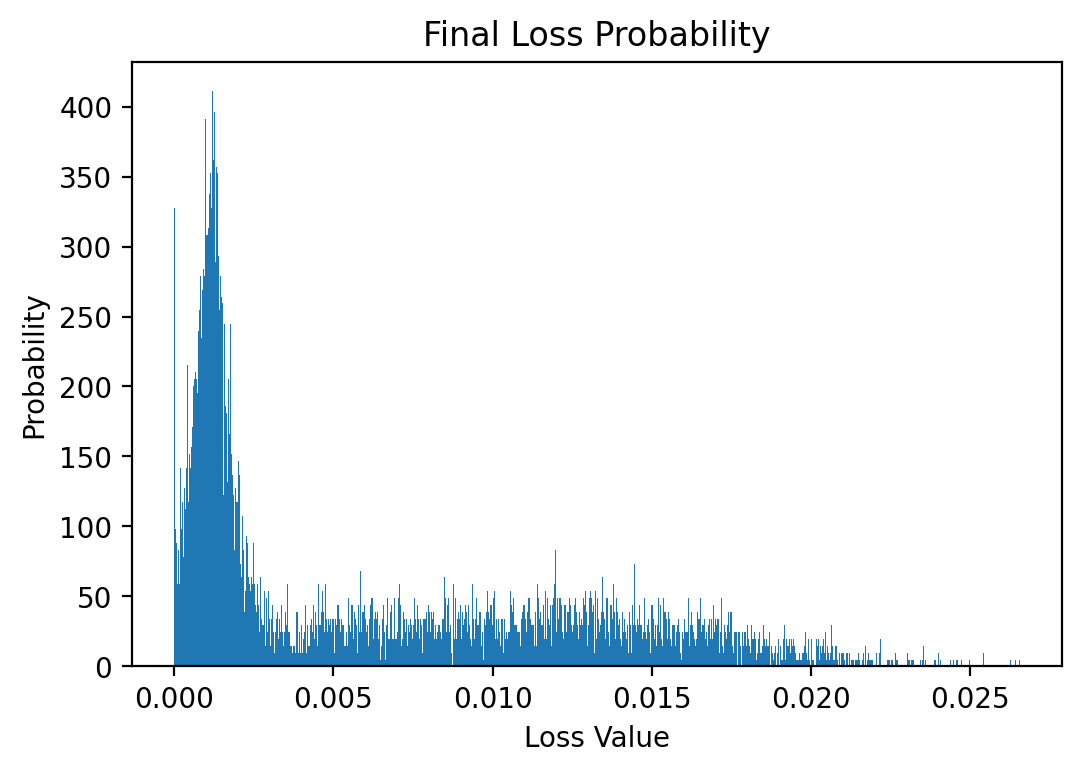

In [ ]:
#LOSSES:

#the `losses` list is a list of loss over all epochs for 1 coordinate across all timesteps... ie shape = (no of coordinates, no of epochs)
#will plot the loss for all coordinates into 1 plot
#then will plot the histogram of all final losses for each coordinate
#then work out the mean, median, sd etc. of the final losses

os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data/') #change directory to save in specific folder



#loss plot:

plt.figure()

for i in range(    np.shape(losses)[0]    ): #plot for all coordinates
  plt.plot(  np.arange(steps),  losses[i], label="Cost for Coordinate Number {}".format(i))


plt.legend()
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("Network Training Cost for Coordinate Number {}")
plt.savefig('All Coordinate Losses.png')
plt.close()







#loss histogram:
final_losses = losses[0:,  steps-1:steps] #final value in all loss arrays (ie for all coordinates)
np.savetxt("final_losses.csv", final_losses, delimiter=",") #save final losses as csv


plt.hist(final_losses, density=True, bins=1000)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Loss Value')
plt.title('Final Loss Probability')
plt.savefig('Final_Loss_Histogram.png')
#plt.show()



#mean, sd etc of final losses:
mean = np.mean(final_losses)
sd  = np.std(final_losses)

print('The Mean of Final Losses for all Coordinates is: ', mean)
print('The Standard Deviation of Final Losses for all Coordinates is: ', sd)

In [ ]:
#loss plots for 3 different coordinates:


os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data/') #change directory to save in specific folder


plt.figure()

for i in [2000, 4000, 6500]: #plot for all coordinates
  plt.plot(  np.arange(steps),  losses[i], label="Cost for Coordinate Number {}".format(i))

plt.title("Network Training Cost for 3 Coordinate Numbers".format(i))
plt.legend()

plt.xlabel("Steps")
plt.ylabel("Cost")

plt.savefig('3_Coordinate_Losses.png')

plt.close()







os.chdir('/content/drive/My Drive/Internships/UKAEA Internship/data/block2_heat') #change back directory